# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Problem Statement

Denoise the leaf images using deep learning techniques

## Learning Objectives

At the end of the Mini Hackathon, you will be able to :
* Denoise healthy/diseased leaf images using Autoencoder
* Visualize the denoised images

In [1]:
#@title Mini Hackathon Walkthrough Video
from IPython.display import HTML

HTML("""<video width="500" height="300" controls>
  <source src="https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/M3_Mini_Hackathon1_Plant_Images_Denoising.mp4" type="video/mp4">
</video>
""")

## Background

Crop losses due to diseases are a major threat to food security every year, across countries.  Conventionally, plant diseases were detected through a visual examination of the affected plants by plant pathology experts. This was often possible only after major damage had already occurred, so treatments were of limited or no use. Recently, access to smartphone based image capturing has highly increased amongst farmers and agriculturists. This has led to the successful adoption of plant disease diagnostic applications based on deep learning techniques. This is of immense value in the field of agriculture and an excellent tool for faster identification and treatment of crop diseases. It holds key importance in preventing crop based food and economic losses. 
## Dataset and Methodology

The dataset for this Mini-Hackathon is derived from the 'Plant Village' Dataset.Around 4500 images of healthy and diseased leaves and their labels have been taken from the 'Plant Village' Dataset. The 4500 images consist of 5 different classes - Bell Pepper Healthy, Bell Pepper Bacterial Spot, Potato Healthy, Potato Early Blight and Potato Late Blight. The original pictures have been clicked in a well controlled environment with very less noise in the images. This is not how real world data may look like.  So we have added noise to the original images to form a noisy dataset. We can use deep learning techniques such as an autoencoder for obtaining denoised images. 


## References:

[Plant Village Dataset Description](https://drive.google.com/file/d/1xGhK-KhhE8W_lfr3l6KT_9K8prHDRb9_/view?usp=sharing)


[Deep Learning for Plant Disease Detection](https://drive.google.com/file/d/1V7NgFs-YGG3G-pz3OJf2X-KQxOGRZzRu/view?usp=sharing)

[Denoising Autoencoder motivational expt](https://drive.google.com/file/d/1Sm1CDAhXDVlv9nFEjFMeYJ9eIwvoQIIZ/view?usp=sharing)


## Grading = 20 Marks

## Setup Steps

In [2]:
#@title Run this cell to download the dataset

from IPython import get_ipython
ipython = get_ipython()
  
notebook="M3_Mini_Hackathon1_Plant_Images_Denoising" #name of the notebook
Answer = "This notebook is graded by mentors on the day of hackathon"
def setup():
   ipython.magic("sx wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/PlantVillage_Noisy_Dataset.zip")
   ipython.magic("sx unzip -qq PlantVillage_Noisy_Dataset.zip")
   print ("Setup completed successfully")
   return

setup()

Setup completed successfully


**Import Libraries**

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import os
from torchvision.utils import save_image

In [2]:
### To test whether GPU instance is present in the system of not.
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
device

Using PyTorch version: 1.5.1+cu101 CUDA: True


device(type='cuda')

In [3]:
seed = 22
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.cuda.empty_cache()

## **Stage 1:** Data Preparation

### 2 Marks - > Prepare the dataset

1. Define transformations.
2. Load the dataset with the defined transformations.

AxesImage(54,36;334.8x217.44)


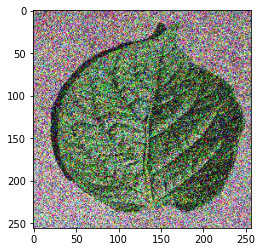

In [4]:
from PIL import Image
img_raw = Image.open("/content/PlantVillage/Noisy_Dataset/Train_Data/Potato___healthy/Potato_Healthy_1.jpg")
print(plt.imshow(img_raw))

AxesImage(54,36;334.8x217.44)


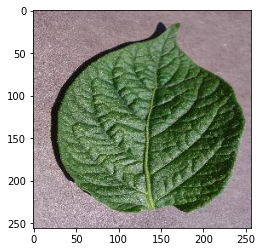

In [5]:
img_raw = Image.open("/content/PlantVillage/Pure_Dataset/Train_Data/Potato___healthy/Potato_Healthy_1.jpg")
print(plt.imshow(img_raw))

In [6]:
img_raw.size

(256, 256)

In [7]:
# YOUR CODE HERE for the transforming the dataset
image_size = (128,128)

transformations =  transforms.Compose([
        # transforms.Resize(image_size),
        # transforms.RandomHorizontalFlip(p=0.5),
        # transforms.RandomVerticalFlip(p=0.5),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

In [8]:
# YOUR CODE HERE for preparing trainloader and testloader set
batch_size = 32

noisy_train = datasets.ImageFolder('/content/PlantVillage/Noisy_Dataset/Train_Data', transform = transformations)
pure_train = datasets.ImageFolder('/content/PlantVillage/Pure_Dataset/Train_Data',transform=transformations)

train_dataset = []
for i in range(len(noisy_train)):
  train_dataset.append((noisy_train[i][0],pure_train[i][0],noisy_train[i][1]))

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

In [9]:
for (X_noise, X_pure, y_train) in train_loader:
    print('X_noise:', X_noise.size(), 'type:', X_noise.type())
    print('X_pure:', X_pure.size(), 'type:', X_pure.type())
    y_train = y_train.float().unsqueeze(1)
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_noise: torch.Size([32, 3, 256, 256]) type: torch.FloatTensor
X_pure: torch.Size([32, 3, 256, 256]) type: torch.FloatTensor
y_train: torch.Size([32, 1]) type: torch.FloatTensor


In [61]:
X_noise[0].max(), X_noise[0].min()

(tensor(1.), tensor(0.))

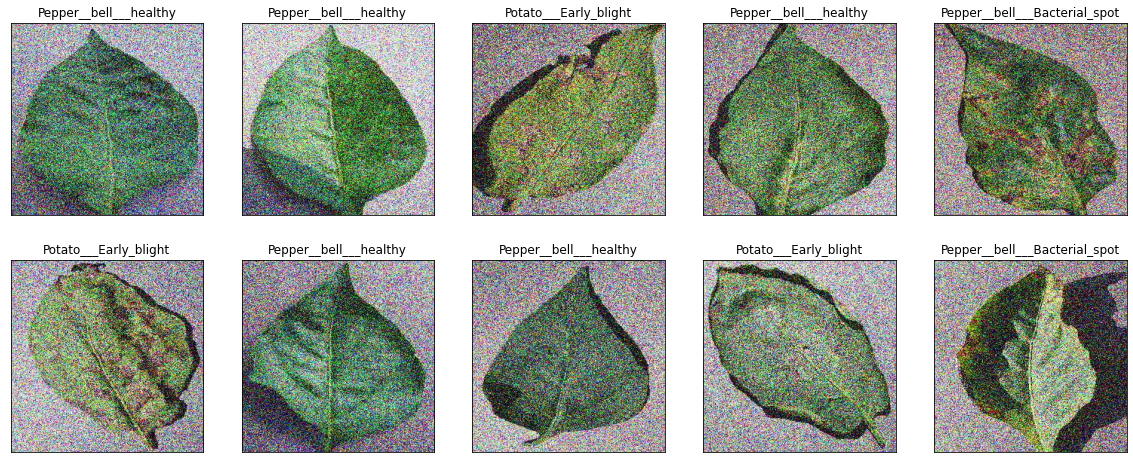

In [11]:
import numpy as np

def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

dataiter = iter(train_loader)
images_n, images_p, labels = dataiter.next()
images_n = images_n.numpy() # convert images to numpy for display
classes = noisy_train.classes

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 8))
# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images_n[idx])
    ax.set_title(classes[labels[idx]])

## **Stage 2:** Build and Train the Model



### 4 Marks -> Write the encoder and decoder layers in one class

1. Extract only the images' data as we do not use the labels to train the autoencoder network
2. Define the Autoencoder neural network
    *  First define the layers required in the  __init__ function.
    *  Build the neural network in the forward() function.

[Hint](https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/)

In [12]:
# YOUR CODE HERE for constructing an autoencoder model
class ConvAEModel(nn.Module):
    def __init__(self):
        super(ConvAEModel, self).__init__()
        
    # encoder layers    
        # Convolution Layer 1 
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #output size of first layer is 8x64x64

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU()

            
        )
        #output size of encode layer is 64x16x16
    
    #decoder layers
      #Deconv Layer 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32,kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=32, out_channels=16,kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=16, out_channels=8,kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=8, out_channels=3,kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )
        
         
    def forward(self, x):
        out1 = self.encoder(x)
        out2 = self.decoder(out1)

        return out2

### 4 Marks -> Train the Model and calculate the loss for dataset for each epoch.

1. Declare the loss function and optimizer
2. Create a directory for saving the output images.
2. Train the model
   *  Extract the image features only as we do not take the labels to train the autoencoder network.
   * Calculate the loss.
   * Append the loss values after every epoch and print them.
   * Save the output (denoised) images in a directory. 

In [14]:
# YOUR CODE HERE for declaring the loss function and optimizer 
ae_model = ConvAEModel()
ae_model = ae_model.to(device)
print(ae_model)

#criterion = # YOUR CODE HERE : Explore and declare loss function
criterion = nn.MSELoss()

#optimizer = # YOUR CODE HERE : Explore on the optimizer and define with the learning rate
optimizer = torch.optim.AdamW(ae_model.parameters(), lr=0.001)

ConvAEModel(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(3

In [15]:
# YOUR CODE HERE for defining a function for creating the directory
def make_dir():
    image_dir = '/content/Reconstructed_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
 
def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 3, 256, 256)
    save_image(img, '/content/Reconstructed_Images/ae_image{}.jpg'.format(epoch))

In [16]:
# YOUR CODE HERE. 

# Train the model and print the loss at each epoch. Also save the output (denoised) images in a directory. 
def train(epoch,loss_vector):
  ae_model.train()
  correct, train_loss = 0,0
  for batch_id, (images,clean, _) in enumerate(train_loader):

      images = images.to(device)
      clean = clean.to(device)
      
      optimizer.zero_grad()
      outputs = ae_model(images)
      loss = criterion(outputs, clean)
      train_loss += loss.item()

      loss.backward()
      optimizer.step()
      
  train_loss /= len(train_loader)
  loss_vector.append(train_loss)

  if epoch % 5 == 0:
    save_decoded_image(outputs.cpu().data, epoch)

In [17]:
# YOUR CODE HERE 

# Record loss of the train denoised images
%%time
epochs = 30

lossv = []
make_dir()
for epoch in range(1, epochs + 1):
    train(epoch, lossv)
    print('{}: Train set: Loss: {:.4f} '.format(epoch, lossv[-1]))

1: Train set: Loss: 0.0368 
2: Train set: Loss: 0.0141 
3: Train set: Loss: 0.0101 
4: Train set: Loss: 0.0086 
5: Train set: Loss: 0.0079 
6: Train set: Loss: 0.0076 
7: Train set: Loss: 0.0074 
8: Train set: Loss: 0.0071 
9: Train set: Loss: 0.0069 
10: Train set: Loss: 0.0067 
11: Train set: Loss: 0.0067 
12: Train set: Loss: 0.0066 
13: Train set: Loss: 0.0066 
14: Train set: Loss: 0.0064 
15: Train set: Loss: 0.0064 
16: Train set: Loss: 0.0064 
17: Train set: Loss: 0.0064 
18: Train set: Loss: 0.0063 
19: Train set: Loss: 0.0063 
20: Train set: Loss: 0.0062 
21: Train set: Loss: 0.0062 
22: Train set: Loss: 0.0062 
23: Train set: Loss: 0.0062 
24: Train set: Loss: 0.0062 
25: Train set: Loss: 0.0061 
26: Train set: Loss: 0.0061 
27: Train set: Loss: 0.0061 
28: Train set: Loss: 0.0061 
29: Train set: Loss: 0.0061 
30: Train set: Loss: 0.0060 
CPU times: user 1min 41s, sys: 11.4 s, total: 1min 52s
Wall time: 1min 53s


## **Stage 3:** Visualize the Denoised images 

### 3 Marks -> Verify the denoised images and compare with original noisy images
1. Plot the original noisy images.
2. Plot denoised images which are saved in the directory.
3. Verify whether denoised images have less noise compared to original noisy images

**Hint:** If the noise is not reduced in the denoised images then revise the autoencoder architecture.

In [18]:
# YOUR CODE HERE for plotting and verifying the images (original noisy images and denoising images)
dataiter = iter(train_loader)
images, clean, _ = dataiter.next()

images = images.to(device)

# get sample outputs
output = ae_model(images)

output = output.cpu().detach().numpy() # use detach() because output requires grad
images = images.cpu().numpy()
clean = clean.cpu().numpy()

# plot the first five input images and then reconstructed images
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
    
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(clean[idx])
    ax.set_title(classes[labels[idx]])

Output hidden; open in https://colab.research.google.com to view.

## **Stage 4:** Test the Model

### 4 Marks -> Evaluate model with the given test data

1. Extract only the images of test loader data as we do not use the labels for the autoencoder network
2. Pass the test images through the autoencoder model to get the denoised images of the test data. 
3. Calculate the loss of the test images

In [19]:
# YOUR CODE HERE for recording the loss of the test dataset
noisy_test = datasets.ImageFolder('/content/PlantVillage/Noisy_Dataset/Test_Data', transform = transformations)
pure_test = datasets.ImageFolder('/content/PlantVillage/Pure_Dataset/Test_Data',transform=transformations)

test_dataset = []
for i in range(len(noisy_test)):
  test_dataset.append((noisy_test[i][0],pure_test[i][0],noisy_test[i][1]))

test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [21]:
ae_model.eval()
test_loss = 0
with torch.no_grad():
  for data, target,_ in test_loader:
      data, target = data.to(device), target.to(device)
      output = ae_model(data)
      test_loss += criterion(output, target).item()

test_loss /= len(test_loader)

print('Test set: Average loss: {:.4f}'.format(test_loss))

Test set: Average loss: 0.0059


### 3 Marks -> Visualizing and verifying test images with the original test noisy dataset

In [22]:
# YOUR CODE HERE for verification and visualization of the test denoised images and original test noisy images
dataiter = iter(test_loader)
images, clean, _ = dataiter.next()
images = images.to(device)
output = ae_model(images)

output = output.cpu().detach().numpy() # use detach() because output requires grad
images = images.cpu().numpy()
clean = clean.cpu().numpy()

# plot the first five input images and then reconstructed images
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
    
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(clean[idx])
    ax.set_title(classes[labels[idx]])


Output hidden; open in https://colab.research.google.com to view.

## (Optional)
You can further apply the CNN or SKlearn classifier to predict the label of denoised images.

Classify the images using CNN

Note: Use torch.cuda.empty_cache() and less batch size so that it will not give any runtime error on memory usage.

1. Get the dataloader of these denoised images with the labels.
2. Calculate the train and test accuracy of the denoised images.
**Hint:** You can reuse the CNN architecture of previous Mini-Hackathon "M2_Mini_Hackathon2_CNN_with_Pytorch" for the classification.

In [23]:
train_dataset= datasets.ImageFolder('/content/PlantVillage/Pure_Dataset/Train_Data',transform=transformations)
val_dataset = datasets.ImageFolder('/content/PlantVillage/Pure_Dataset/Test_Data',transform=transformations)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [24]:
len(train_loader.dataset[0])

2

In [25]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution Layer 1 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        #output size of first layer is 8x64x64

        # Convolution Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        #output size of second layer is 16x16x16
        
        # Convolution Layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        #output size of third layer is 32x4x4
        
     
        # YOUR CODE HERE for defining the Fully Connected Layer and also define LogSoftmax
        self.fc1 = nn.Linear(32*4*4, 32)
        self.fc2 = nn.Linear(32,5)

    def forward(self, x):
        # YOUR CODE HERE for the Convolutional Layers and Maxpool based on the defined Convolutional layers
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)

        # YOUR CODE HERE for flattening the output of the final pooling layer to a vector. Flattening is simply arranging the 3D volume of numbers into a 1D vector
        out3 = out3.view(out3.size(0), -1)
        out4 = self.fc1(out3)
        out5 = self.fc2(out4)

        # YOUR CODE HERE for returning the output of LogSoftmax after applying Fully Connected Layer
        return F.log_softmax(out5, dim=1)

In [39]:
clf = CNNModel()
clf = clf.to(device)
print(clf)

#criterion = # YOUR CODE HERE : Explore and declare loss function
criterion = nn.NLLLoss()

#optimizer = # YOUR CODE HERE : Explore on the optimizer and define with the learning rate
optimizer = torch.optim.AdamW(clf.parameters(), lr=0.001)

CNNModel(
  (layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=5, bias=True

In [40]:
def train(epoch,loss_vector,acc_vector):
  clf.train()
  correct, train_loss = 0,0
  for batch_id, (images, labels) in enumerate(train_loader):

      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = clf(images)
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum()
      loss = criterion(outputs, labels)
      train_loss += loss.item()

      loss.backward()
      optimizer.step()
      
  train_loss /= len(train_loader)
  loss_vector.append(train_loss)

  accuracy = 100. * correct/ len(train_loader.dataset)
  acc_vector.append(accuracy)
  # print(f'Train accuracy: {accuracy}; Loss: {train_loss}')

In [41]:
def test(loss_vector, accuracy_vector):
    clf.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
      for data, target in val_loader:
          data, target = data.to(device), target.to(device)
          output = clf(data)
          test_loss += criterion(output, target).item()
          pred = torch.max(output.data,1)[1] # get the index of the max log-probability
          correct += pred.eq(target.data).to(device).sum()

    test_loss /= len(val_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct / len(val_loader.dataset)
    accuracy_vector.append(accuracy)
    
    # print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset), accuracy))

In [42]:
%%time
epochs = 30
seed = 22
torch.manual_seed(seed)

losst, acct = [], []
lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch, losst, acct)
    test(lossv, accv)
    print('{}: Train set: Acc: {:.2f}% Loss: {:.4f}; Test set: Acc: {:.2f}% Loss: {:.4f}'.format(epoch, acct[-1], losst[-1], accv[-1], lossv[-1]))
    if accv[-1] > 95:
      break

1: Train set: Acc: 77.12% Loss: 0.6196; Test set: Acc: 55.67% Loss: 1.1939
2: Train set: Acc: 91.62% Loss: 0.2527; Test set: Acc: 72.78% Loss: 0.7363
3: Train set: Acc: 95.84% Loss: 0.1454; Test set: Acc: 73.96% Loss: 0.7829
4: Train set: Acc: 97.31% Loss: 0.0950; Test set: Acc: 88.34% Loss: 0.3726
5: Train set: Acc: 97.90% Loss: 0.0689; Test set: Acc: 93.18% Loss: 0.1947
6: Train set: Acc: 98.80% Loss: 0.0418; Test set: Acc: 89.89% Loss: 0.2789
7: Train set: Acc: 99.20% Loss: 0.0304; Test set: Acc: 88.03% Loss: 0.5809
8: Train set: Acc: 99.07% Loss: 0.0326; Test set: Acc: 94.48% Loss: 0.1699
9: Train set: Acc: 99.43% Loss: 0.0230; Test set: Acc: 93.99% Loss: 0.1783
10: Train set: Acc: 99.17% Loss: 0.0315; Test set: Acc: 73.59% Loss: 1.0270
11: Train set: Acc: 97.84% Loss: 0.0666; Test set: Acc: 88.34% Loss: 0.4044
12: Train set: Acc: 98.77% Loss: 0.0354; Test set: Acc: 92.37% Loss: 0.2861
13: Train set: Acc: 99.24% Loss: 0.0220; Test set: Acc: 94.54% Loss: 0.1992
14: Train set: Acc: 9

In [53]:
test_dataset= datasets.ImageFolder('/content/PlantVillage/Noisy_Dataset/Test_Data',transform=transformations)
clf_test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True)

ae_model.eval()
clf.eval()
y_test = []
y_pred = []
with torch.no_grad():
  for data, target in clf_test_loader:
      data = data.to(device)
      output = ae_model(data)
      pred_value = clf(output)
      # torch.max(pred_value.data,1)[1]
      y_test.append(int(target.cpu()))
      y_pred.append(int(torch.max(pred_value.data,1)[1].cpu()))

In [58]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.47      0.63       308
           1       0.68      1.00      0.81       577
           2       1.00      0.28      0.44       296
           3       0.56      0.98      0.71       300
           4       0.00      0.00      0.00       132

    accuracy                           0.68      1613
   macro avg       0.63      0.55      0.52      1613
weighted avg       0.71      0.68      0.62      1613



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
test_dataset= datasets.ImageFolder('/content/PlantVillage/Noisy_Dataset/Test_Data',transform=transformations)
clf_test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True)

ae_model.eval()
clf.eval()
y_test = []
y_pred = []
with torch.no_grad():
  for data, target in clf_test_loader:
      data = data.to(device)
      # output = ae_model(data)
      pred_value = clf(data)
      # torch.max(pred_value.data,1)[1]
      y_test.append(int(target.cpu()))
      y_pred.append(int(torch.max(pred_value.data,1)[1].cpu()))

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.23      0.05      0.08       308
           1       0.94      0.10      0.19       577
           2       0.20      1.00      0.33       296
           3       0.00      0.00      0.00       300
           4       0.00      0.00      0.00       132

    accuracy                           0.23      1613
   macro avg       0.27      0.23      0.12      1613
weighted avg       0.42      0.23      0.14      1613



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
